In [1]:
from tqdm import tqdm
import os
import time
from random import randint
 
import gc 
import numpy as np
from scipy import stats
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import KFold

import nibabel as nib
import pydicom as pdm
import nilearn as nl
import nilearn.plotting as nlplt
import h5py

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as anim
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import seaborn as sns
import imageio
from skimage.transform import resize
from skimage.util import montage

from IPython.display import Image as show_gif
from IPython.display import clear_output
from IPython.display import YouTubeVideo

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import MSELoss

# !pip install albumentations==0.4.6
import albumentations as A
# from albumentations.pytorch import ToTensor, ToTensorV2


from albumentations import Compose, HorizontalFlip
# from albumentations.pytorch import ToTensor, ToTensorV2 

import warnings
warnings.simplefilter("ignore")

import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  



# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras import preprocessing


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

C:\Users\srini\AppData\Local\Temp\ipykernel_35292\2521239759.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [25]:
!pip install albumentations==0.4.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=c97f046a75eae1b83c0cef379a54fa2a8ff9f1c4a6d991a50e7fe126a95c65c6
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.3.0
    Uninstalling albumentations-1.3.0:
      Successfully uninstalled albumentations-1.3.0


In [2]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',   
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE - RED
    2 : 'EDEMA',  # Green
    3 : 'ENHANCING' # original 4 -> converted into 3 later, Yellow
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 # first slice of volume that we will include

IMG_SIZE=128

Text(0.5, 1.0, 'Mask')

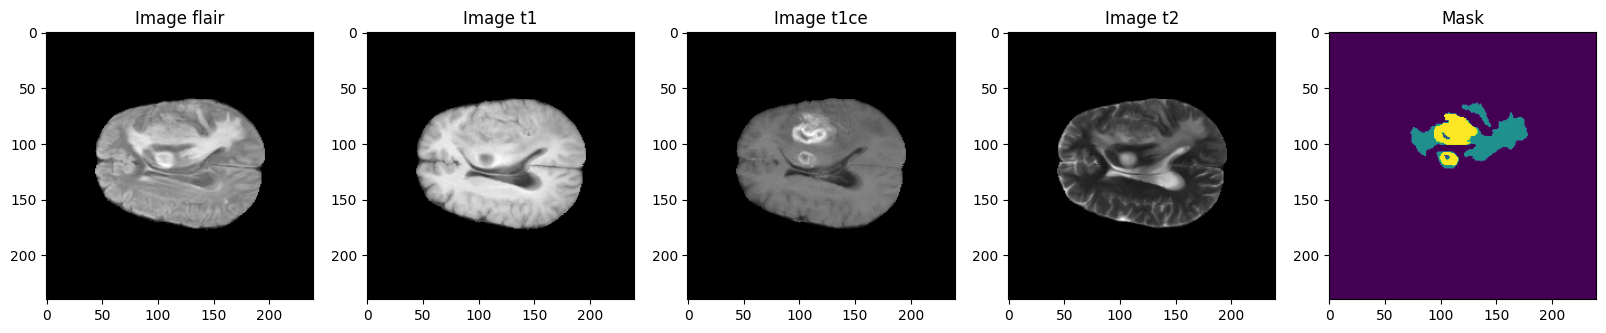

In [3]:
VAL_DATASET_PATH = 'C:/Users/srini/Downloads/MICCAI_BraTS_2019_Data_Training/HGG/'
TRAIN_DATASET_PATH = 'C:/Users/srini/Downloads/MICCAI_BraTS_2019_Data_Training/LGG/'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS19_TMC_09043_1/BraTS19_TMC_09043_1_flair.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS19_TMC_09043_1/BraTS19_TMC_09043_1_t1.nii').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS19_TMC_09043_1/BraTS19_TMC_09043_1_t1ce.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS19_TMC_09043_1/BraTS19_TMC_09043_1_t2.nii').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS19_TMC_09043_1/BraTS19_TMC_09043_1_seg.nii').get_fdata()


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

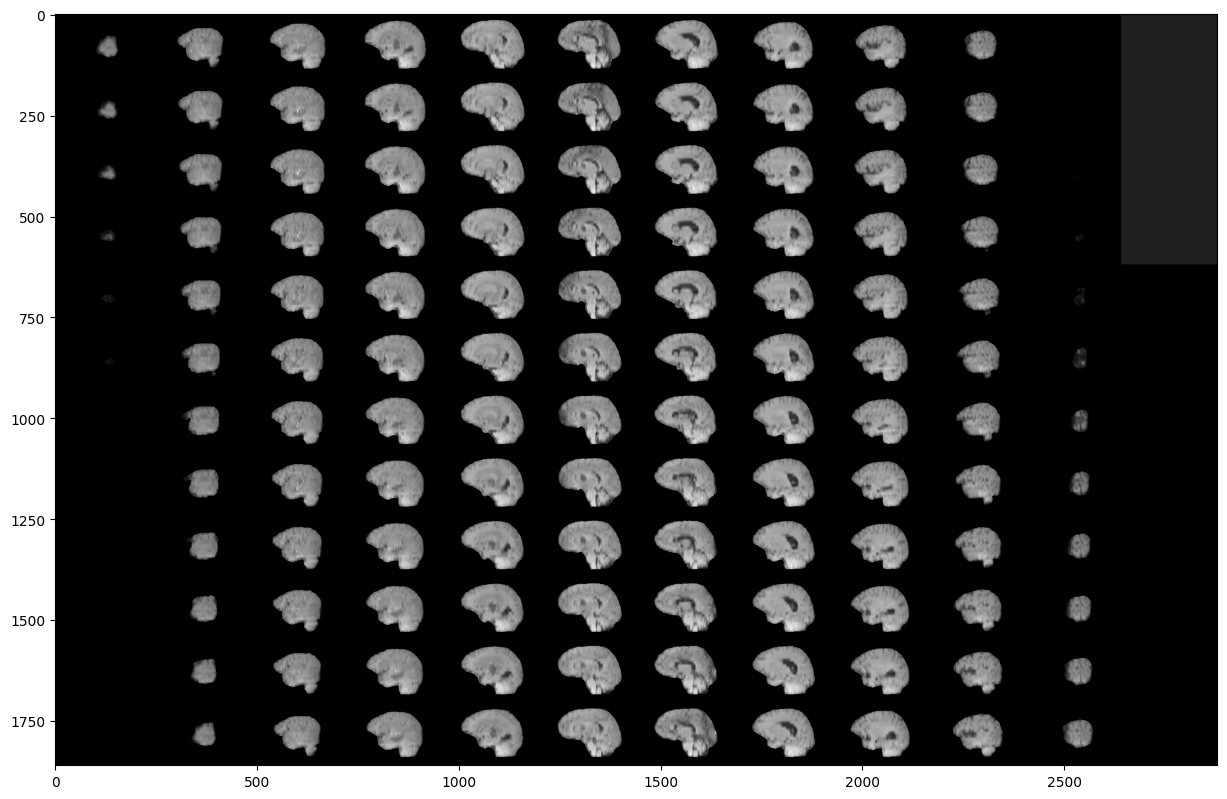

In [4]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize=True), cmap ='gray')

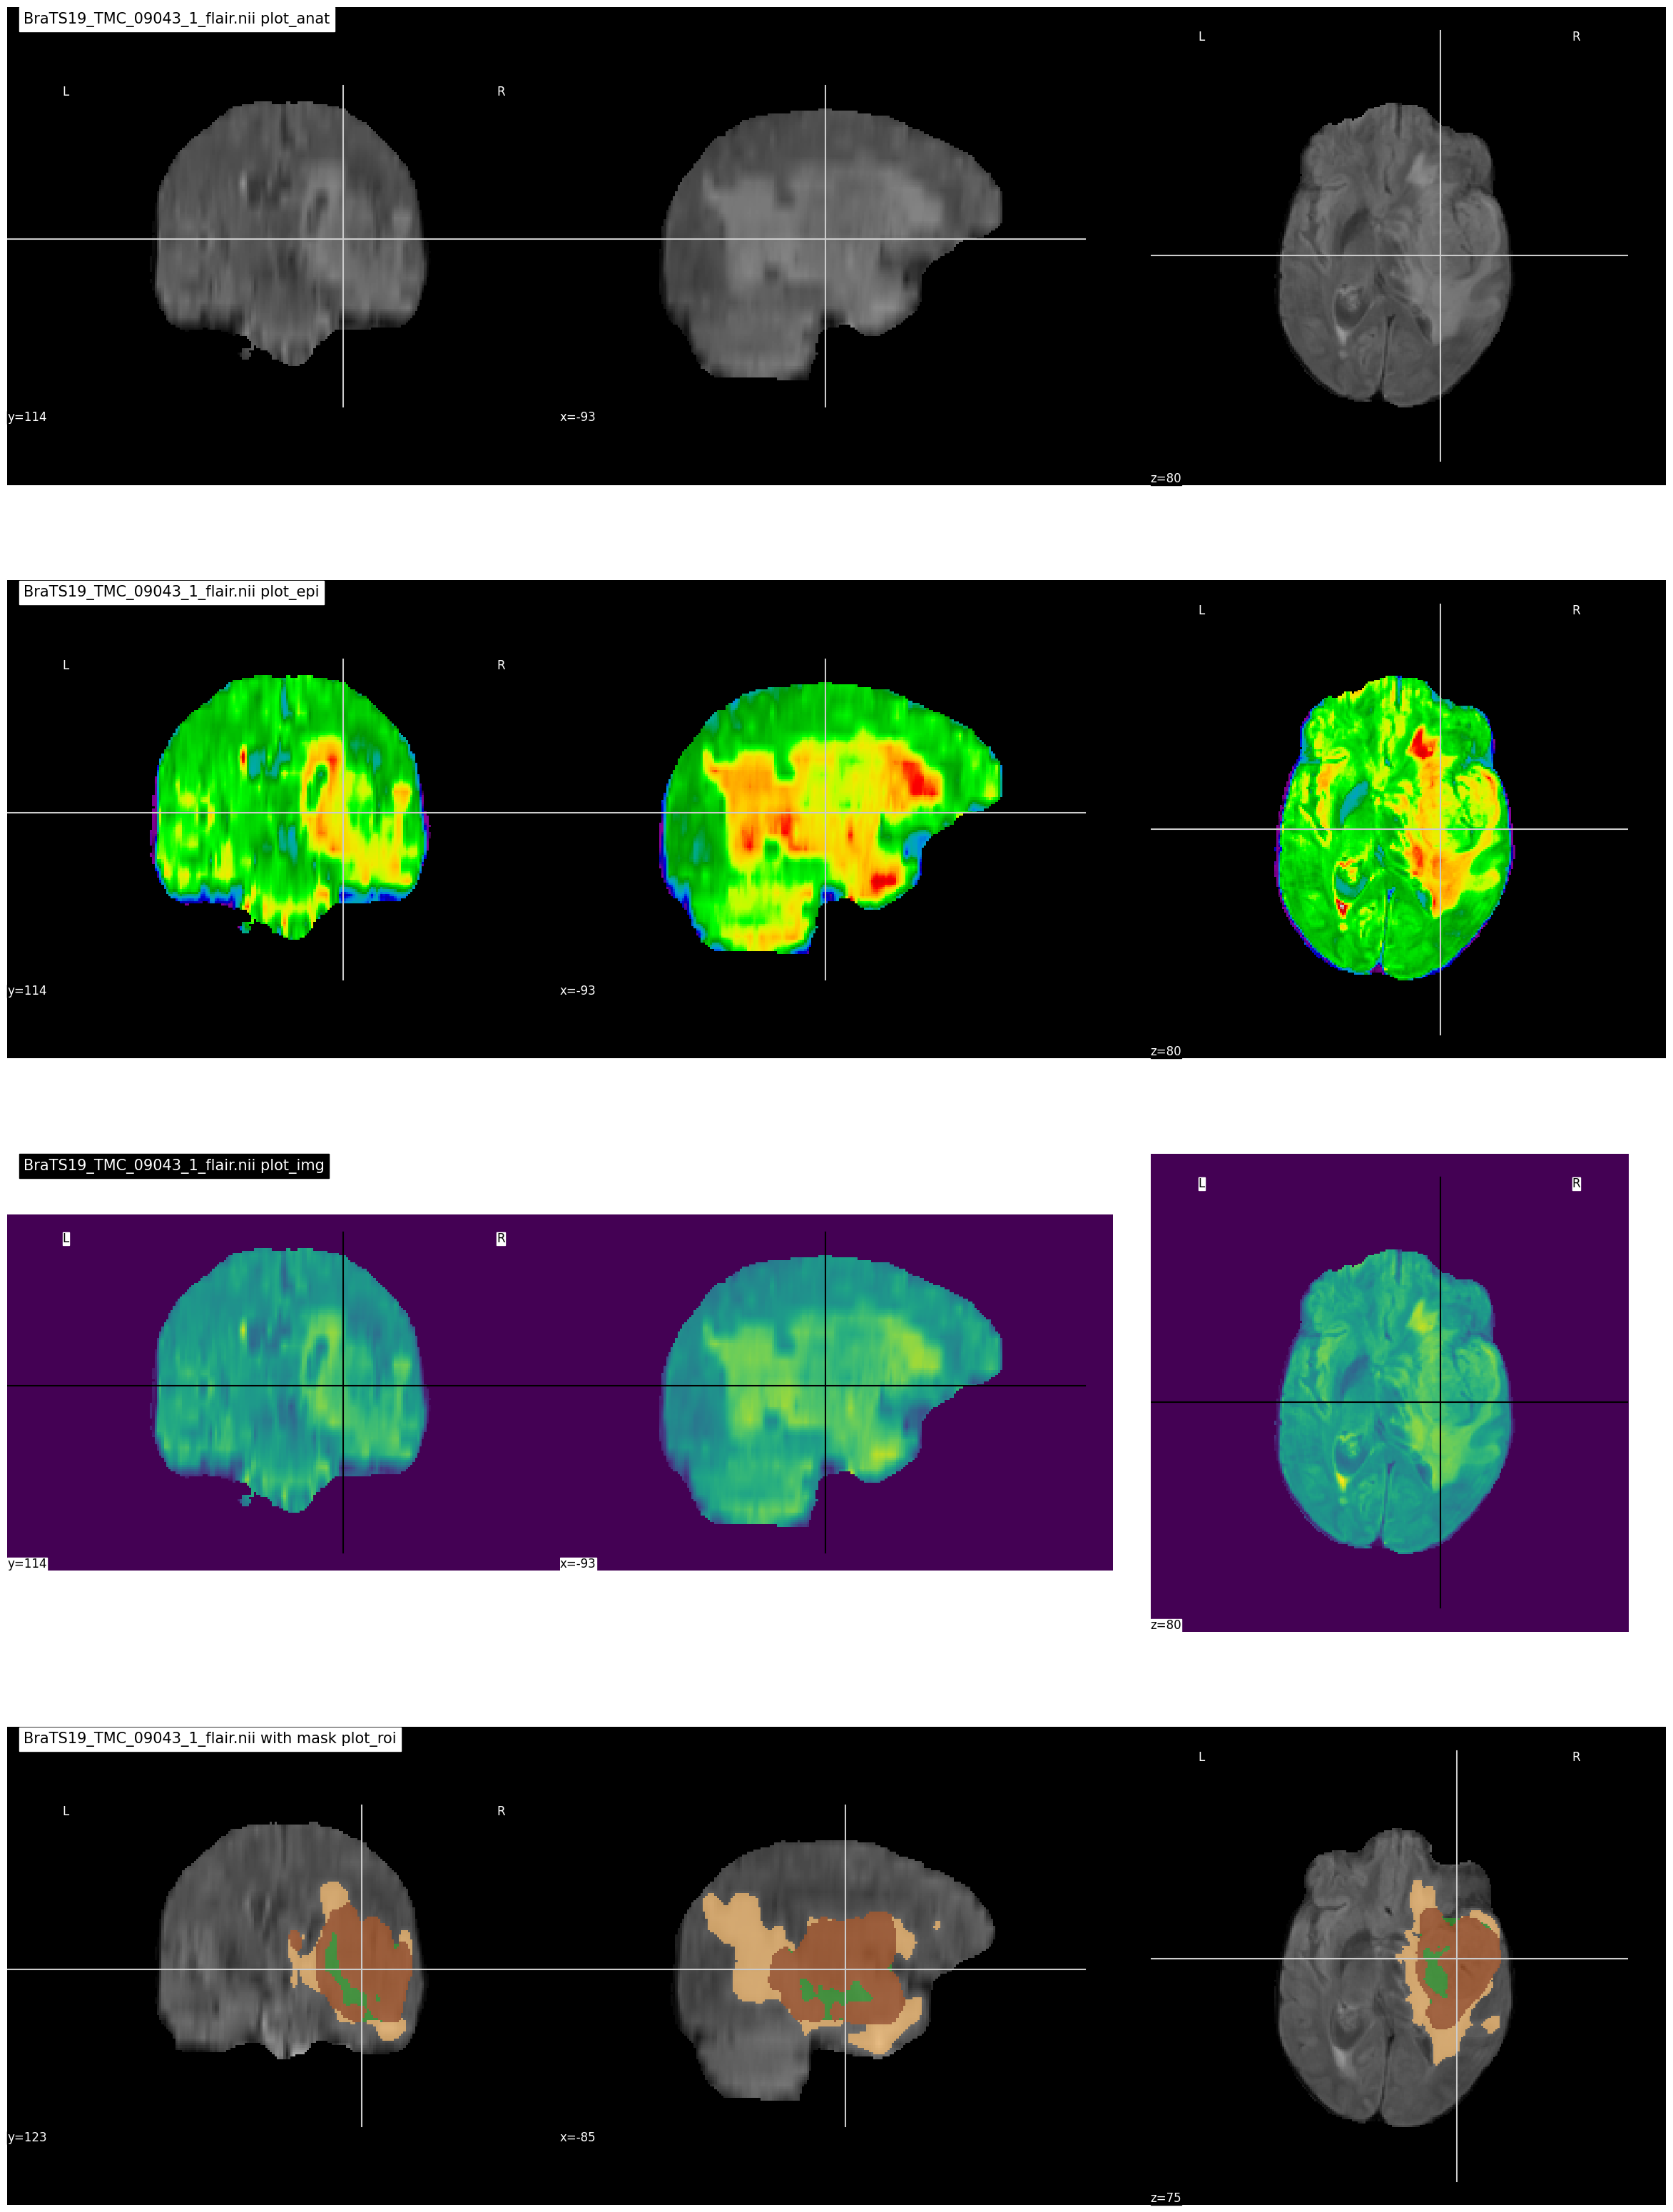

In [5]:
niimg = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS19_TMC_09043_1/BraTS19_TMC_09043_1_flair.nii')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS19_TMC_09043_1/BraTS19_TMC_09043_1_seg.nii')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='BraTS19_TMC_09043_1_flair.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='BraTS19_TMC_09043_1_flair.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='BraTS19_TMC_09043_1_flair.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask, 
               title='BraTS19_TMC_09043_1_flair.nii with mask plot_roi',
               bg_img=niimg, 
               axes=axes[3], cmap='Paired')

plt.show()

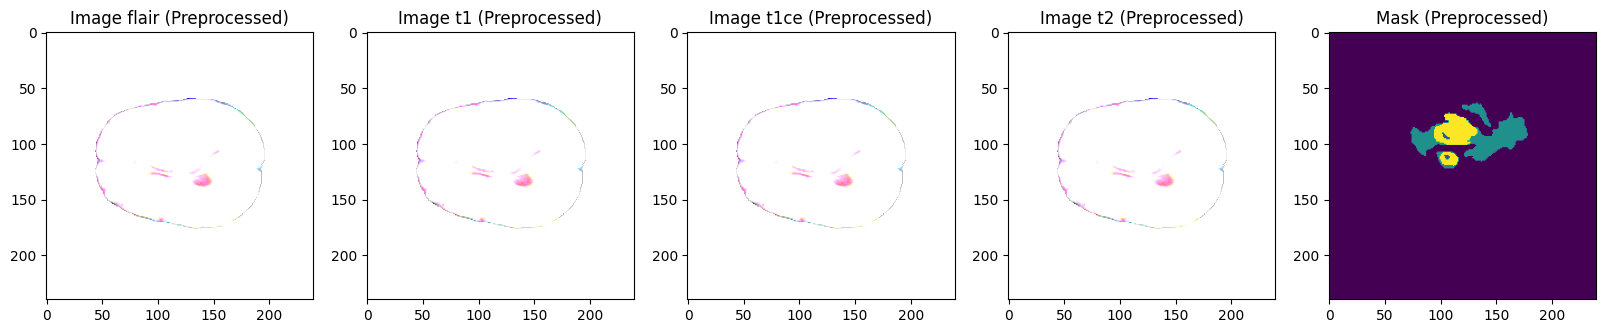

In [6]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Define paths
VAL_DATASET_PATH = 'C:/Users/srini/Downloads/MICCAI_BraTS_2019_Data_Training/HGG/'
TRAIN_DATASET_PATH = 'C:/Users/srini/Downloads/MICCAI_BraTS_2019_Data_Training/LGG/'

# Load MRI images and mask
test_image_flair = nib.load(TRAIN_DATASET_PATH + 'BraTS19_TMC_09043_1/BraTS19_TMC_09043_1_flair.nii').get_fdata()
test_image_t1 = nib.load(TRAIN_DATASET_PATH + 'BraTS19_TMC_09043_1/BraTS19_TMC_09043_1_t1.nii').get_fdata()
test_image_t1ce = nib.load(TRAIN_DATASET_PATH + 'BraTS19_TMC_09043_1/BraTS19_TMC_09043_1_t1ce.nii').get_fdata()
test_image_t2 = nib.load(TRAIN_DATASET_PATH + 'BraTS19_TMC_09043_1/BraTS19_TMC_09043_1_t2.nii').get_fdata()
test_mask = nib.load(TRAIN_DATASET_PATH + 'BraTS19_TMC_09043_1/BraTS19_TMC_09043_1_seg.nii').get_fdata()

# Define preprocessing function
def preprocess_data(images, mask):
    # Normalize each image volume independently
    scaler = StandardScaler()
    images_normalized = scaler.fit_transform(images.reshape(-1, images.shape[-1])).reshape(images.shape)
    
    # Clip values to be in the range [0, 1]
    images_normalized = np.clip(images_normalized, 0, 1)
    
    # Normalize mask to be in the range [0, 1]
    mask_normalized = mask / np.max(mask)
    
    return images_normalized, mask_normalized

# Preprocess images and mask
test_images_preprocessed, test_mask_preprocessed = preprocess_data(
    np.stack([test_image_flair, test_image_t1, test_image_t1ce, test_image_t2], axis=-1),
    test_mask
)

# Display preprocessed images and mask
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 10))
slice_w = 25
ax1.imshow(test_images_preprocessed[:, :, test_images_preprocessed.shape[0] // 2 - slice_w], cmap='gray')
ax1.set_title('Image flair (Preprocessed)')
ax2.imshow(test_images_preprocessed[:, :, test_images_preprocessed.shape[0] // 2 - slice_w], cmap='gray')
ax2.set_title('Image t1 (Preprocessed)')
ax3.imshow(test_images_preprocessed[:, :, test_images_preprocessed.shape[0] // 2 - slice_w], cmap='gray')
ax3.set_title('Image t1ce (Preprocessed)')
ax4.imshow(test_images_preprocessed[:, :, test_images_preprocessed.shape[0] // 2 - slice_w], cmap='gray')
ax4.set_title('Image t2 (Preprocessed)')
ax5.imshow(test_mask_preprocessed[:, :, test_mask_preprocessed.shape[0] // 2 - slice_w])
ax5.set_title('Mask (Preprocessed)')

plt.show()


In [7]:
def dice_coef_metric(probabilities: torch.Tensor,
                     truth: torch.Tensor, 
                     treshold: float = 0.5,
                     eps: float = 1e-9) -> np.ndarray:
    """
    Calculate Dice score for data batch.
    Params:
        probobilities: model outputs after activation function.
        truth: truth values.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        Returns: dice score aka f1.
    """
    scores = []
    num = probabilities.shape[0] 
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)
    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = 2.0 * (truth_ * prediction).sum()
        union = truth_.sum() + prediction.sum()
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)


def jaccard_coef_metric(probabilities: torch.Tensor,
               truth: torch.Tensor,
               treshold: float = 0.5,
               eps: float = 1e-9) -> np.ndarray:
    """
    Calculate Jaccard index for data batch.
    Params:
        probobilities: model outputs after activation function.
        truth: truth values.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        Returns: jaccard score aka iou."
    """
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)

    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = (prediction * truth_).sum()
        union = (prediction.sum() + truth_.sum()) - intersection + eps
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)


class Meter:
    '''factory for storing and updating iou and dice scores.'''
    def __init__(self, treshold: float = 0.5):
        self.threshold: float = treshold
        self.dice_scores: list = []
        self.iou_scores: list = []
    
    def update(self, logits: torch.Tensor, targets: torch.Tensor):
        """
        Takes: logits from output model and targets,
        calculates dice and iou scores, and stores them in lists.
        calculates using the above declare functions 
        """
        probs = torch.sigmoid(logits)
        dice = dice_coef_metric(probs, targets, self.threshold)
        iou = jaccard_coef_metric(probs, targets, self.threshold)
        
        # appending to the respective lists 
        self.dice_scores.append(dice)
        self.iou_scores.append(iou)
    
    def get_metrics(self) -> np.ndarray:
        """
        Returns: the average of the accumulated dice and iou scores.
        """
        dice = np.mean(self.dice_scores)
        iou = np.mean(self.iou_scores)
        return dice, iou


class DiceLoss(nn.Module):
    """Calculate dice loss."""
    def __init__(self, eps: float = 1e-9):
        super(DiceLoss, self).__init__()
        self.eps = eps
        
    def forward(self,
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        
        num = targets.size(0)
        probability = torch.sigmoid(logits)
        probability = probability.view(num, -1)
        targets = targets.view(num, -1)
        assert(probability.shape == targets.shape)
        
        intersection = 2.0 * (probability * targets).sum()
        union = probability.sum() + targets.sum()
        dice_score = (intersection + self.eps) / union
        #print("intersection", intersection, union, dice_score)
        return 1.0 - dice_score
        
        
class BCEDiceLoss(nn.Module):
    """Compute objective loss: BCE loss + DICE loss."""
    def __init__(self):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        
    def forward(self, 
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        
        # logits are the images 
        # target are the masks 
        assert(logits.shape == targets.shape)
        dice_loss = self.dice(logits, targets)
        bce_loss = self.bce(logits, targets)
        
        # binary cross entropy loss & dice loss 
        return bce_loss + dice_loss
    
# helper functions for testing.  
def dice_coef_metric_per_classes(probabilities: np.ndarray,
                                    truth: np.ndarray,
                                    treshold: float = 0.5,
                                    eps: float = 1e-9,
                                    classes: list = ['WT', 'TC', 'ET']) -> np.ndarray:
    """
    Calculate Dice score for data batch and for each class i.e. 'WT', 'TC', 'ET'
    Params:
        probobilities: model outputs after activation function.
        truth: model targets.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        classes: list with name classes.
        Returns: dict with dice scores for each class.
    """
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = 2.0 * (truth_ * prediction).sum()
            union = truth_.sum() + prediction.sum()
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)
                
    return scores


def jaccard_coef_metric_per_classes(probabilities: np.ndarray, # output of the model in an array format 
               truth: np.ndarray,# masks  
               treshold: float = 0.5, # threshold to whether segment / not 
               eps: float = 1e-9, # smooth 
               classes: list = ['WT', 'TC', 'ET']) -> np.ndarray:
    """
    Calculate Jaccard index for data batch and for each class.
    Params:
        probobilities: model outputs after activation function.
        truth: model targets.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        classes: list with name classes.
        Returns: dict with jaccard scores for each class."
    """
    scores = {key: list() for key in classes}
    # storing all the jaccard coefficients in a list 
    
    num = probabilities.shape[0]
    
    num_classes = probabilities.shape[1]
    
    # segmenting if prob > threshold .i.e. setting to float32 
    predictions = (probabilities >= treshold).astype(np.float32)
    
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = (prediction * truth_).sum()
            union = (prediction.sum() + truth_.sum()) - intersection + eps
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)

    return scores

# UNet + FPN

In [38]:
class ConvReluUpsample(nn.Module):
    def __init__(self, in_channels, out_channels, upsample=False):
        super().__init__()
        self.upsample = upsample
        self.make_upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.block = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, (3,3), stride=1, padding=1, bias=False),
        nn.GroupNorm(32, out_channels),
        nn.ReLU(inplace=True),
        )
    
    def forward(self, x):
        x = self.block(x)
        if self.upsample:
            x = self.make_upsample(x)
        return x
    
class SegmentationBlock(nn.Module):
    def __init__(self, in_channels, out_channels, n_upsamples=0):
        super().__init__()
        
        blocks = [ConvReluUpsample(in_channels, out_channels, upsample=bool(n_upsamples))]
        
        if n_upsamples > 1:
            for _ in range(1, n_upsamples):
                blocks.append(ConvReluUpsample(out_channels, out_channels, upsample=True))
                
        self.block = nn.Sequential(*blocks)
    
    def forward(self, x):
        return self.block(x)

In [39]:
class FPN(nn.Module):
    def __init__(self, n_classes=1, pyramid_channels=256,
                segmentation_channels=256):
        super().__init__()
        
        self.conv_down1 = double_conv(3, 64)
        self.conv_down2 = double_conv(64, 128)
        self.conv_down3 = double_conv(128, 256)
        self.conv_down4 = double_conv(256, 512)
        self.conv_down5 = double_conv(512, 1024)
        self.maxpool = nn.MaxPool2d(2)
        
        self.toplayer = nn.Conv2d(1024, 256, kernel_size=1, stride=1, padding=0)
        
        self.smooth1 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        
        self.latlayer1 =nn.Conv2d(512, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer2 = nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer3 = nn.Conv2d(128, 256, kernel_size=1, stride=1, padding=0)
        
        self.seg_blocks = nn.ModuleList([
            SegmentationBlock(pyramid_channels, segmentation_channels,
                             n_upsamples=n_upsamples) for n_upsamples in [0, 1, 2, 3]
        ])
        
        self.last_conv = nn.Conv2d(256, n_classes, kernel_size=1, stride=1, padding=0)
        
    def upsample_add(self, x, y):
        _, _, h, w = y.size()
        sample = nn.Upsample(size=(h, w), mode="bilinear", align_corners=True)
        return sample(x)+y
    
    def upsample(self, x, h, w):
        sample = nn.Upsample(size=(h, w), mode="bilinear", align_corners=True)
        return sample(x)
        
    def forward(self, x):
        c1 = self.maxpool(self.conv_down1(x))
        c2 = self.maxpool(self.conv_down2(c1))
        c3 = self.maxpool(self.conv_down3(c2))
        c4 = self.maxpool(self.conv_down4(c3))
        c5 = self.maxpool(self.conv_down5(c4))
        
        p5 = self.toplayer(c5)
        p4 = self.upsample_add(p5, self.latlayer1(c4))
        p3 = self.upsample_add(p4, self.latlayer2(c3))
        p2 = self.upsample_add(p3, self.latlayer3(c2))
        
        p4 = self.smooth1(p4)
        p3 = self.smooth2(p3)
        p2 = self.smooth3(p2)
        
        _, _, h, w = p2.size()
        feature_pyramid = [seg_block(p) for seg_block, p in zip(self.seg_blocks, [p2, p3, p4, p5])]
        
        out = self.upsample(self.last_conv(sum(feature_pyramid)), 4*h, 4*w)
        out = torch.sigmoid(out)
        return out

In [40]:
fpn = FPN().to(device)
output = fpn(torch.randn(1,3,256,256).to(device))
print(output.shape)

torch.Size([1, 1, 256, 256])


# Early Stopping

In [47]:
# early stopping
class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

In [48]:
early_stopping = EarlyStopping(tolerance=5, min_delta=10)

# Training

In [49]:
def train_model(model_name, model, train_loader, val_loader, train_loss, optimizer, lr_scheduler, num_epochs):
    print(f"[INFO] Model is initializing... {model_name}")
    
    loss_history = []
    train_history = []
    val_history = []
        
    for epoch in range(num_epochs):
        
        model.train()
        
        losses = []
        train_iou = []
        
        if lr_scheduler:
            warmup_factor = 1.0 / 100
            warmup_iters = min(100, len(train_loader) - 1)
            lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)
        
        for i_step, (data, target) in enumerate(tqdm(train_loader)):
            data = data.to(device)
            target = target.to(device)
            
            
            outputs = model(data)
            
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            
            train_dice = dice_coef_metric(out_cut, target.data.cpu().numpy())
            
            loss = train_loss(outputs, target)
            
            losses.append(loss.item())
            train_iou.append(train_dice)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            if lr_scheduler:
                lr_scheduler.step()
                
        val_mean_iou = compute_iou(model, val_loader)
        
        loss_history.append(np.array(losses).mean())
        train_history.append(np.array(train_iou).mean())
        val_history.append(val_mean_iou)
        
        # early stopping
        early_stopping(np.array(losses).mean(), val_mean_iou)
        if early_stopping.early_stop:
            print("[INFO] Early stopping at epoch:", i)
            break
        
        print("Epoch [%d]" % (epoch))
        print("Mean loss on train:", np.array(losses).mean(), 
              "\nMean DICE on train:", np.array(train_iou).mean(), 
              "\nMean DICE on validation:", val_mean_iou)
        
    return loss_history, train_history, val_history

In [50]:
def compute_iou(model, loader, threshold=0.3):
    valloss = 0
    
    with torch.no_grad():

        for i_step, (data, target) in enumerate(loader):
            
            data = data.to(device)
            target = target.to(device)
            
            outputs = model(data)

            out_cut = np.copy(outputs.data.cpu().detach())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0

            picloss = dice_coef_metric(out_cut, target.data.cpu().numpy())
            valloss += picloss

    return valloss / i_step

In [51]:
# lr_scheduler
def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):
    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)

# Train FPN

In [56]:
fpn_optimizer = torch.optim.Adamax(fpn.parameters(), weight_decay=1e-3)

In [57]:
%%time
num_ep = 50

fpn_lh, fpn_th, fpn_vh = train_model("FPN", fpn, train_dataloader, val_dataloader, bce_dice_loss, fpn_optimizer, False, num_ep)

[INFO] Model is initializing... FPN


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [0]
Mean loss on train: 0.8690435136357944 
Mean DICE on train: 0.2031954714403498 
Mean DICE on validation: 0.45877741270422


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [1]
Mean loss on train: 0.6017104660471281 
Mean DICE on train: 0.4817826447329422 
Mean DICE on validation: 0.5212608264721963


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [2]
Mean loss on train: 0.5114494894941648 
Mean DICE on train: 0.5526294638997643 
Mean DICE on validation: 0.6781926201033391


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [3]
Mean loss on train: 0.48021632495025796 
Mean DICE on train: 0.5830413291353987 
Mean DICE on validation: 0.6089050838002165


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [4]
Mean loss on train: 0.4555573490758737 
Mean DICE on train: 0.6063892135562682 
Mean DICE on validation: 0.6491871992038638


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [5]
Mean loss on train: 0.4374910476307074 
Mean DICE on train: 0.6194074012427048 
Mean DICE on validation: 0.6642948207714275


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [6]
Mean loss on train: 0.42874932872752347 
Mean DICE on train: 0.6275041293142806 
Mean DICE on validation: 0.6869106756118545


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [7]
Mean loss on train: 0.4107094502697388 
Mean DICE on train: 0.645925230979854 
Mean DICE on validation: 0.6899750282961029


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [8]
Mean loss on train: 0.4137882772833109 
Mean DICE on train: 0.6392654637565066 
Mean DICE on validation: 0.6266070692751531


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [9]
Mean loss on train: 0.42955884474019207 
Mean DICE on train: 0.62529842611475 
Mean DICE on validation: 0.6169084708371737


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [10]
Mean loss on train: 0.3957694721718629 
Mean DICE on train: 0.6565929850686038 
Mean DICE on validation: 0.739420142945574


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [11]
Mean loss on train: 0.4008169456074635 
Mean DICE on train: 0.6504592718430248 
Mean DICE on validation: 0.6965862001168


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [12]
Mean loss on train: 0.3782975780467192 
Mean DICE on train: 0.6714751700210381 
Mean DICE on validation: 0.7368893847062503


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [13]
Mean loss on train: 0.38333174847066404 
Mean DICE on train: 0.6671448556190362 
Mean DICE on validation: 0.723355723093503


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [14]
Mean loss on train: 0.3658373922109604 
Mean DICE on train: 0.6820661427065543 
Mean DICE on validation: 0.7741022903106612


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [15]
Mean loss on train: 0.35916146722932657 
Mean DICE on train: 0.6882749254364403 
Mean DICE on validation: 0.7719224724808953


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [16]
Mean loss on train: 0.36871748603880405 
Mean DICE on train: 0.679249585195933 
Mean DICE on validation: 0.7470859062606134


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [17]
Mean loss on train: 0.3725350261976322 
Mean DICE on train: 0.6779906280850727 
Mean DICE on validation: 0.6943642547624437


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [18]
Mean loss on train: 0.3320009173204502 
Mean DICE on train: 0.7122339573888552 
Mean DICE on validation: 0.7704139296855222


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [19]
Mean loss on train: 0.3227632130185763 
Mean DICE on train: 0.7210789453368507 
Mean DICE on validation: 0.800456856542269


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [20]
Mean loss on train: 0.31796474878986675 
Mean DICE on train: 0.7224427120084177 
Mean DICE on validation: 0.7944586857084093


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [21]
Mean loss on train: 0.31246776282787325 
Mean DICE on train: 0.7308325753047508 
Mean DICE on validation: 0.7546894198354274


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [22]
Mean loss on train: 0.30833529370526475 
Mean DICE on train: 0.7351232601531074 
Mean DICE on validation: 0.8219774969156665


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [23]
Mean loss on train: 0.3083806117375692 
Mean DICE on train: 0.7330539363314605 
Mean DICE on validation: 0.8200641683072962


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [24]
Mean loss on train: 0.30285100849966207 
Mean DICE on train: 0.7370074223026581 
Mean DICE on validation: 0.8526550966836809


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [25]
Mean loss on train: 0.28474408586819966 
Mean DICE on train: 0.7550528708686187 
Mean DICE on validation: 0.8143318322738365


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [26]
Mean loss on train: 0.2860775082061688 
Mean DICE on train: 0.7531803055132209 
Mean DICE on validation: 0.8201877632136175


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [27]
Mean loss on train: 0.2773211551209291 
Mean DICE on train: 0.7600534280792769 
Mean DICE on validation: 0.8565861339419282


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [28]
Mean loss on train: 0.281295741101106 
Mean DICE on train: 0.7570977029591736 
Mean DICE on validation: 0.8200999809195224


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [29]
Mean loss on train: 0.2700996613750855 
Mean DICE on train: 0.7674825928313077 
Mean DICE on validation: 0.8241780770854586


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [30]
Mean loss on train: 0.2647936479498943 
Mean DICE on train: 0.7720649741979579 
Mean DICE on validation: 0.8100418472416417


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [31]
Mean loss on train: 0.27842038733263813 
Mean DICE on train: 0.7595586243146424 
Mean DICE on validation: 0.8055593490646277


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [32]
Mean loss on train: 0.2659579776227474 
Mean DICE on train: 0.7694754645902484 
Mean DICE on validation: 0.8491025226473927


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [33]
Mean loss on train: 0.24903615961472195 
Mean DICE on train: 0.7862969279181357 
Mean DICE on validation: 0.8557790934020653


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [34]
Mean loss on train: 0.25187881477177143 
Mean DICE on train: 0.7822237473806131 
Mean DICE on validation: 0.8490348155422717


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [35]
Mean loss on train: 0.24122174630562465 
Mean DICE on train: 0.7926619568849197 
Mean DICE on validation: 0.8579463537511671


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [36]
Mean loss on train: 0.24691720809787512 
Mean DICE on train: 0.7878342889294544 
Mean DICE on validation: 0.8387131131054683


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [37]
Mean loss on train: 0.23557955144594114 
Mean DICE on train: 0.7981718628190647 
Mean DICE on validation: 0.8330675823580945


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [38]
Mean loss on train: 0.23787443997959296 
Mean DICE on train: 0.7953249556614616 
Mean DICE on validation: 0.8266101956411236


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [39]
Mean loss on train: 0.22749740307529767 
Mean DICE on train: 0.8042521551391845 
Mean DICE on validation: 0.8549132419184686


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [40]
Mean loss on train: 0.23048899670441944 
Mean DICE on train: 0.8015199053690315 
Mean DICE on validation: 0.845082223089187


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [41]
Mean loss on train: 0.21368038083116214 
Mean DICE on train: 0.8170838256549281 
Mean DICE on validation: 0.8523394834724488


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [42]
Mean loss on train: 0.22241381431619325 
Mean DICE on train: 0.8085412480780501 
Mean DICE on validation: 0.8588586716452862


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [43]
Mean loss on train: 0.2232683005432288 
Mean DICE on train: 0.8082604527077716 
Mean DICE on validation: 0.8191203990242841


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [44]
Mean loss on train: 0.2149489094192783 
Mean DICE on train: 0.8152776689329577 
Mean DICE on validation: 0.8618311021510362


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [45]
Mean loss on train: 0.21819925835976997 
Mean DICE on train: 0.8129144567605718 
Mean DICE on validation: 0.8213226106874884


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [46]
Mean loss on train: 0.21755515125890573 
Mean DICE on train: 0.8130136543305251 
Mean DICE on validation: 0.8715052119266936


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [47]
Mean loss on train: 0.21028738487511872 
Mean DICE on train: 0.8195089051693804 
Mean DICE on validation: 0.8907242253992482


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [48]
Mean loss on train: 0.20716365439196427 
Mean DICE on train: 0.8218674603359799 
Mean DICE on validation: 0.8657977337488078


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [49]
Mean loss on train: 0.2038212097560366 
Mean DICE on train: 0.8255315629619292 
Mean DICE on validation: 0.8472091662491731
CPU times: user 29min 24s, sys: 39.6 s, total: 30min 4s
Wall time: 31min 36s


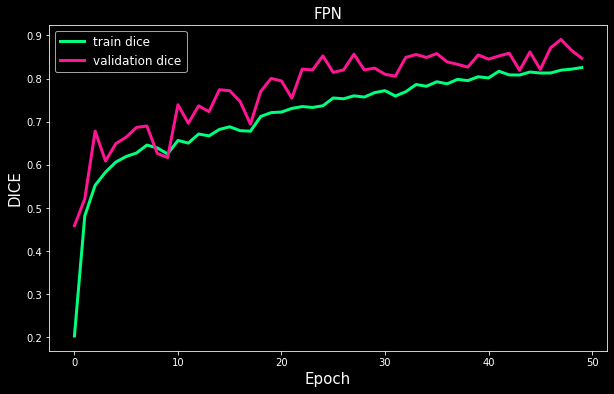

In [58]:
plot_model_history("FPN", fpn_th, fpn_vh, num_ep)